In [1]:
# fill nan inclinations, Omega, argp with random selections
# need to do a disk integration since there isn't a single path that light takes
#    - need to account for scattered light from the visible portion of the illuminated hemisphere

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import EPPE_Simulator as eppe
import astropy.constants as const

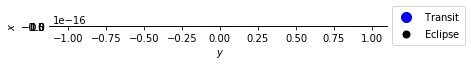

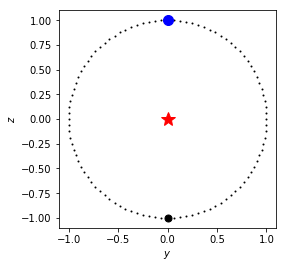

/home/taylor/anaconda3/lib/python3.6/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/taylor/anaconda3/lib/python3.6/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


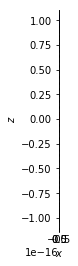

In [31]:
orb = eppe.KeplerOrbit(inc=0., Omega=90., Porb=3)
orb.plot_orbit()
plt.show()

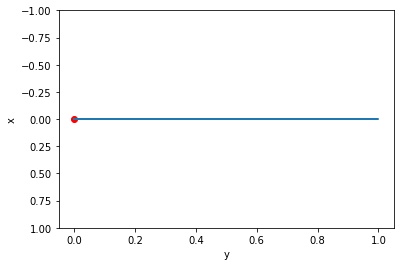

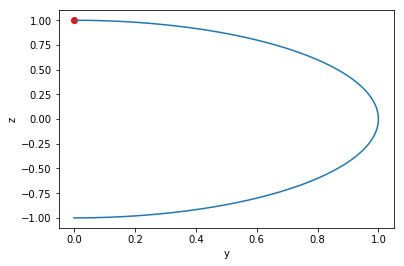

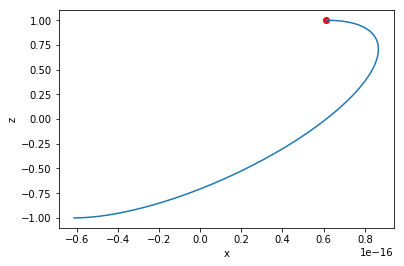

In [32]:
times = np.linspace(0, orb.Porb/2., 500)
x, y, z = orb.xyz(times)

plt.plot(y[0]/const.au, x[0]/const.au, 'o', c='r')
plt.plot(y/const.au, x/const.au)
plt.ylim(1,-1)
plt.xlabel('y')
plt.ylabel('x')
plt.show()

plt.plot(y[0]/const.au, z[0]/const.au, 'o', c='r')
plt.plot(y/const.au, z/const.au)
plt.xlabel('y')
plt.ylabel('z')
plt.show()

plt.plot(x[0]/const.au, z[0]/const.au, 'o', c='r')
plt.plot(x/const.au, z/const.au)
plt.xlabel('x')
plt.ylabel('z')
plt.show()

In [33]:
def compute_scat_angle(times, orb, dist):
    times = times.copy()
    
    # fix scattering plane during transit and eclipse
    times[np.abs(times%orb.Porb-orb.t_trans)<(1./24./3600.)] += (1./24./3600.)
    times[np.abs(times%orb.Porb-orb.t_ecl)<(1./24./3600.)] += (1./24./3600.)

    r = np.array(orb.xyz(times))
    d = np.array([dist, 0, 0])[:,np.newaxis]
    Z = np.array([0, 0, 1])[:,np.newaxis]
    norm = np.cross(r, d, axis=0)
    
    return 180/np.pi*np.arccos(np.sum(Z*norm, axis=0)
                               /(np.sqrt(np.sum(Z**2, axis=0))*np.sqrt(np.sum(norm**2, axis=0))))

In [37]:
times = np.linspace(0,orb.Porb,10001,endpoint=True)
angles = eppe.compute_scatPlane_angle(times, orb, 100*const.pc.value)

r = np.array(orb.xyz(times))
scatAngle2 = eppe.xyz_to_scatAngle(r, 100*const.pc.value)

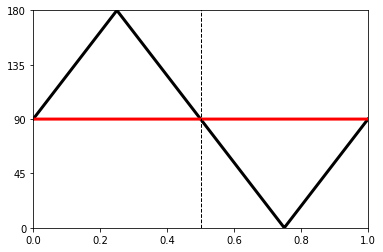

In [38]:
plt.plot(times/orb.Porb, angles, lw=3, c='k')
plt.plot(times/orb.Porb, scatAngle2, lw=3, c='r')
plt.xlim(0,1)
plt.ylim(0,180)
plt.yticks(np.linspace(0,180,5,endpoint=True))
plt.axvline(0.5,0,360, c='k', lw=1, ls='--')
plt.show()

In [40]:
systems = eppe.Systems(load=True)
mission = eppe.EPPE()
fp, fstar, noise = mission.observe(systems, 3600)

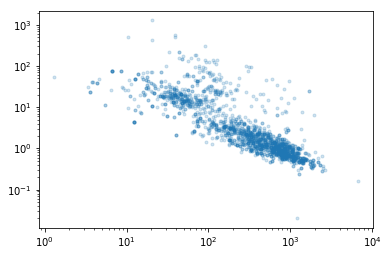

In [41]:
plt.loglog(systems.catalogue['dist']/const.pc.value, fstar/noise, '.', alpha=0.2)
plt.show()

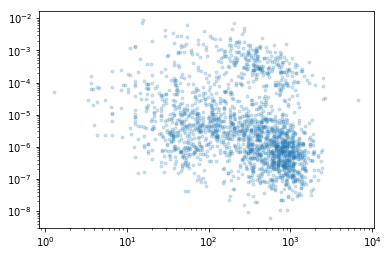

In [42]:
plt.loglog(systems.catalogue['dist']/const.pc.value, fp/noise, '.', alpha=0.2)
plt.show()

In [43]:
phi = 45
Ii = 1.
Qi = 0.
Ui = 0
Vi = 0
stokes = np.array([Ii, Qi, Ui, Vi]).reshape(-1,1)
print(stokes)

[[1.]
 [0.]
 [0.]
 [0.]]


In [44]:
def polarization(times, stokes, dist, Porb, a, inc=90, e=0, argp=90, Omega=270, t0=0):
    orb = eppe.KeplerOrbit(Porb=Porb, a=a, inc=inc, e=e, argp=argp, Omega=Omega, t0=t0)
    
    r = np.array(orb.xyz(times))
    angs = eppe.xyz_to_scatAngle(r, dist)
    
    
    lambertCurve = eppe.lambert_scatter(angs+180, stokes)[0]
    rayStokesCurve = np.array([eppe.rayleigh_scatter(ang, stokes) for ang in angs])[:,:,0].T*lambertCurve[np.newaxis,:]
    print(np.array([eppe.rayleigh_scatter(ang, stokes) for ang in angs])[:,:,0].T.shape)
    print(rayStokesCurve.shape)
    rayPolCurve = np.sqrt(rayStokesCurve[1,:]**2+rayStokesCurve[2,:]**2)/rayStokesCurve[0,:]
    
    return rayPolCurve, rayStokesCurve

(4, 1000)
(4, 1000)


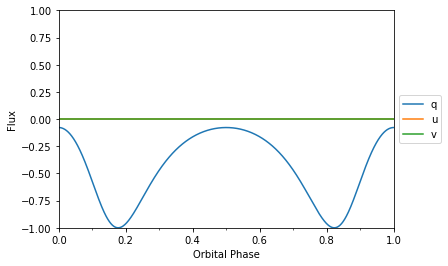

In [53]:
for i in range(len(systems.catalogue['a'][:1])):
    # i = 0

    # randomly generate start time, and use determined integration duration
    t0 = 0
    t1 = systems.catalogue['per'][i]

    dist = systems.catalogue['dist'][i]
    Porb = systems.catalogue['per'][i]
    a = systems.catalogue['a'][i]
    inc = systems.catalogue['inc'][i]
#     inc = 0
    e = systems.catalogue['e'][i]
#     e = 0
    # argp = systems.catalogue['argp'][i]
    argp = 90
    # Omega = systems.catalogue['Omega'][i]
    Omega = 270

    times = np.linspace(t0, t1, 1000)
    phases = eppe.t_to_phase(times, Porb)
    polCurve, polStokesCurve = polarization(times, stokes, dist, Porb, a, inc=inc, e=e, argp=argp, Omega=Omega, t0=0)

    # plt.plot(phases, polCurve*100)
    # plt.ylabel('P (%)')
    # plt.xlabel('Orbital Phase')
    # plt.ylim(0,100)
    # plt.xlim(0,1)
    # plt.gca().set_xticks(np.linspace(0,1,11,endpoint=True), minor=True)
    # plt.show()

    plt.plot(phases, polStokesCurve[1,:]/polStokesCurve[0,:], label='q')
    plt.plot(phases, polStokesCurve[2,:]/polStokesCurve[0,:], label='u')
    plt.plot(phases, polStokesCurve[3,:]/polStokesCurve[0,:], label='v')
    plt.ylabel('Flux')
    plt.xlabel('Orbital Phase')
    plt.xlim(0,1)
    plt.ylim(-1,1)
    plt.gca().set_xticks(np.linspace(0,1,11,endpoint=True), minor=True)
    plt.legend(loc=6, bbox_to_anchor=(1,0.5))
    plt.show()

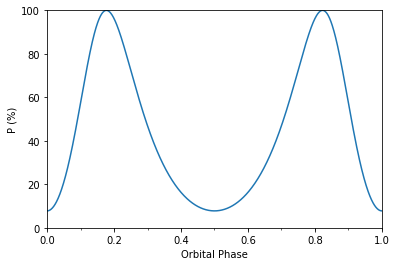

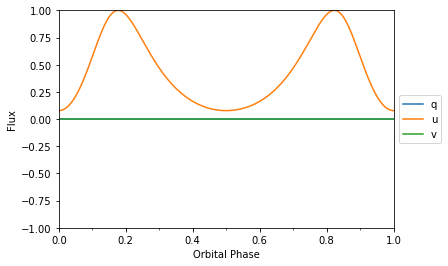

In [57]:
newStokesCurve = eppe.rotate(45,polStokesCurve)

plt.plot(phases, 100*np.sqrt(newStokesCurve[1,:]**2+newStokesCurve[2,:]**2)/newStokesCurve[0,:])
plt.ylabel('P (%)')
plt.xlabel('Orbital Phase')
plt.xlim(0,1)
plt.ylim(0,100)
plt.gca().set_xticks(np.linspace(0,1,11,endpoint=True), minor=True)
plt.show()

plt.plot(phases, newStokesCurve[1,:]/newStokesCurve[0,:], label='q')
plt.plot(phases, newStokesCurve[2,:]/newStokesCurve[0,:], label='u')
plt.plot(phases, newStokesCurve[3,:]/newStokesCurve[0,:], label='v')
plt.ylabel('Flux')
plt.xlabel('Orbital Phase')
plt.xlim(0,1)
plt.ylim(-1,1)
plt.gca().set_xticks(np.linspace(0,1,11,endpoint=True), minor=True)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.show()

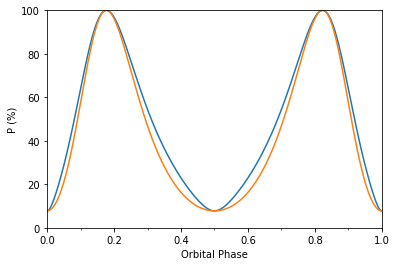

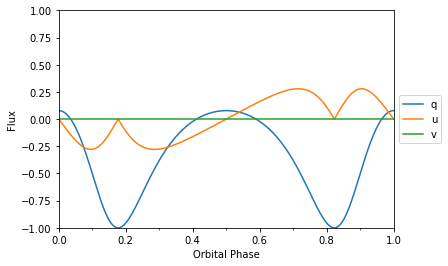

In [65]:
orb = eppe.KeplerOrbit(Porb=Porb, a=a, inc=inc, e=e, argp=argp, Omega=Omega, t0=t0)
newStokesCurve = eppe.rotate(eppe.compute_scatPlane_angle(times, orb, dist),polStokesCurve)

plt.plot(phases, 100*np.sqrt(polStokesCurve[1,:]**2+newStokesCurve[2,:]**2)/newStokesCurve[0,:])
plt.plot(phases, 100*np.sqrt(newStokesCurve[1,:]**2+newStokesCurve[2,:]**2)/newStokesCurve[0,:])
plt.ylabel('P (%)')
plt.xlabel('Orbital Phase')
plt.xlim(0,1)
plt.ylim(0,100)
plt.gca().set_xticks(np.linspace(0,1,11,endpoint=True), minor=True)
plt.show()

plt.plot(phases, newStokesCurve[1,:]/newStokesCurve[0,:], label='q')
plt.plot(phases, newStokesCurve[2,:]/newStokesCurve[0,:], label='u')
plt.plot(phases, newStokesCurve[3,:]/newStokesCurve[0,:], label='v')
plt.ylabel('Flux')
plt.xlabel('Orbital Phase')
plt.xlim(0,1)
plt.ylim(-1,1)
plt.gca().set_xticks(np.linspace(0,1,11,endpoint=True), minor=True)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.show()